## Using Machine Learning in Python to Predicting Weather Temperatures
### Part 1: Collecting Weather Data From WeatherUnderground

### Introduction

This is the first article of a multi-part series on using Python an d Machine Learning to build models to predict weather temperatures based off data collected from Weather Underground. The series will be comprised of three different articles describing the major aspects of a Machine Learning project. The topics to be covered are:

  1.  data collection and processing
  2.  linear regression models
  3.  neural network models

The data used in this series will be collected from Weather Underground's free tier API web service. I will be using the requests library to interact with the API to pull in weather data since 2015 for the city of Lincoln Nebraska. Once collected the data will need to be process and aggregated into a format that is suitable for data analysis then cleaned.

The second article will focus on analyzing the trends in the data with the goal of selecting appropriate features for building a Linear Regression model using the statsmodels and SciKitLearn Python libraries. I will discuss the importance of understanding the assumptions necessary for using a Linear Regression model and demonstrate how to evaluate the features to build a robust model. This article will conclude with a discussion of Linear Regression model testing and validation.

The final article will focus on using Neural Networks. I will compare the process of building a Neural Network model, interpreting the results and, overall accuracy between the Linear Regression model built in the prior article and the Neural Network model.

### Getting Familiar with Weather Underground

Getting Familiar with Weather Underground
Weather Underground is a company that collects and distributes data on various weather measurements around the globe. The company provides a swath of API's that are available for both commercial and non-commercial uses. In this article, I will describe how to programmatically pull daily weather data from Weather Underground using their free tier of service available for non-commercial purposes.
If you would like to follow along with the tutorial you will want to sign up for their free developer account here. This account provides an API key to access the web service at a rate of 10 requests per minute and up to a total of 500 requests in a day.
Weather Underground provides many different web service API's to access data from but, the one we will be concerned with is their history API. The history API provides a summary of various weather measurements for a city and state on a specific day.
The format of the request for the history API resource is as follows:
http://api.wunderground.com/api/API_KEY/history_YYYYMMDD/q/STATE/CITY.json
  -  API_KEY: is the API_KEY that Weather Underground provides with your account
  -  YYYYMMDD: is a string representing the target date of your request
  -  STATE: is the two letter state abbreviation in the United States
  -  CITY: is the name of the city associated with the state you requested

### Making Requests to the API

To make requests to the Weather Underground history API and process the returned data I will make use of a few standard libraries as well as some popular third party libraries.  Below is a table of the libraries I will be using and their description.  For installation instructions please refer to the listed documentation.

| Library     | Description of Usage                               | Source           |
|-------------------------------------------------------------------------------------|
| [datetime](https://docs.python.org/3/library/datetime.html)    | Used to increment our requests by day              | Standard Library |
| [time](https://docs.python.org/3/library/time.html)        | Used to delay requests to stay under 10 per minute | Standard Library |
| [collections](https://docs.python.org/3/library/collections.html#collections.namedtuple) | Use namedtuples for structured collection of data  | Standard Library |
| [pandas](http://pandas.pydata.org/)      | Used to process, organize and clean the data       | Third Party Library     |
| [requests](http://docs.python-requests.org/en/master/)    | Used to make networked requests to the API         | Third Party Library   |
| [matplotlib](https://matplotlib.org/) | Used for graphical analysis | Third Party Library |

Let us get started by importing these libraries.

In [1]:
from datetime import datetime, timedelta
import time
from collections import namedtuple
import pandas as pd
import requests
import matplotlib.pyplot as plt

Now I will define a couple of constants representing my API_KEY and the BASE_URL of the API endpoint I will be requesting.  Note you will need to signup for an account with Weather Underground and recieve your own API_KEY.  By the time this article is published I will have deactivated this one.

BASE_URL is a string with two place holders represented by curly brackets.  The first {} will be filled by the API_KEY and the second {} will be replaced by a string formatted date.  Both values will be interpolated into the BASE_URL string using the [str.format(...)](https://docs.python.org/2/library/stdtypes.html#str.format) function.

In [2]:
API_KEY = '7052ad35e3c73564'
BASE_URL = "http://api.wunderground.com/api/{}/history_{}/q/NE/Lincoln.json"

Next I will intialize the target date to the first day of the year in 2015.  Then I will specify the features that I would like to parse from the responses returned from the API.  The features are simply the keys present in the history -> dailysummary portion of the JSON response.  Those features are used to define a namedtuple called DailySummary which I'll use to organize the individual request's data in a list of DailySummary tuples.

In [2]:
target_date = datetime(2016, 5, 16)
features = ["date", "meantempm", "meandewptm", "meanpressurem", "maxhumidity", "minhumidity", "maxtempm",
            "mintempm", "maxdewptm", "mindewptm", "maxpressurem", "minpressurem", "precipm"]
DailySummary = namedtuple("DailySummary", features)

In this section I will be making the actual requests to the API and collecting the successful responses using the function defined below.  This function takes the parameters url, api_key, target_date and days.

In [4]:
def extract_weather_data(url, api_key, target_date, days):
    records = []
    for _ in range(days):
        request = BASE_URL.format(API_KEY, target_date.strftime('%Y%m%d'))
        response = requests.get(request)
        if response.status_code == 200:
            data = response.json()['history']['dailysummary'][0]
            records.append(DailySummary(
                date=target_date,
                meantempm=data['meantempm'],
                meandewptm=data['meandewptm'],
                meanpressurem=data['meanpressurem'],
                maxhumidity=data['maxhumidity'],
                minhumidity=data['minhumidity'],
                maxtempm=data['maxtempm'],
                mintempm=data['mintempm'],
                maxdewptm=data['maxdewptm'],
                mindewptm=data['mindewptm'],
                maxpressurem=data['maxpressurem'],
                minpressurem=data['minpressurem'],
                precipm=data['precipm']))
        time.sleep(6)
        target_date += timedelta(days=1)
    return records

I start by defining a list called records which will hold the parsed data as DailySummary namedtuples. The for loop is defined so that it iterates over the loop for number of days passed to the function.

Then the request is formatted using the str.format() function to interpolate the API_KEY and string formatted target_date object.  Once formatted the request variable is passed to the get() method of the requests object and the response is assigned to a variable called response.

With the response returned I want to make sure the request was successful by evaluating that the status code is equal to 200.  If it is successful then I parse the response's body into JSON using the json() method of the returned response object. Chained to the same json() method call I select the indexes of the history and daily summary structures then grab the first item in the dailysummary list and assign that to a variable named data.

Now that I have the dict-like data structure referenced by the data variable I can select the desired fields and instantiate a new instance of the DailySummary namedtuple which is appended to the records list.

Finally, each iteration of the loop concludes by calling the sleep method of the time module to pause the loop's execution for six seconds guaranteeing that no more than 10 requests are made per minute. Then the target_date is incremented by 1 day using the timedelta object of the datetime module so the next iteration of the loop retrieves the daily summary for the following day.

### The First Batch of Requests

Without further delay I will kick off the first set of requests for the maximum allotted daily request under the free developer account of 500.  Then I suggest you grab a refill of your coffee (or other preferred beverage) and get caught up on your favorite TV show because the function will take at least an hour depending on network latency, we have maxed out our request, and this is only about half the data we will be working with.  So, come back tomorrow where I will finish out the last batch of requests then we can start working on processing and formatting the data in a manner suitable for our Machine Learning project.

In [5]:
records = extract_weather_data(BASE_URL, API_KEY, target_date, 500)

### Finishing up the Data Retrieval

Ok, now that it is a new day we have a clean slate and up to 500 requests that can be made to the Weather Underground history API.  Our batch of 500 requests issued yesterday began on January 1st 2015 and ended on May 15th 2016 (assuming you didn't have any failed requests).  Once again let us kick off another batch of 500 requests but, don't go leaving me for the day this time because once this last chunk of data is collected we are going to begin formatting it into a Pandas DataFrame and derive potentially useful features.

In [12]:
# if you closed our terminal or Jupyter Notebook reinitialize your imports and
# variables first and remember to set your target_date to datetime(2016, 5, 16)
records += extract_weather_data(BASE_URL, API_KEY, target_date, 500)

### Setting Up our Pandas DataFrame

Now that I have a nice and sizable records list of DailySummary named tuples I will use it to build out a Pandas DataFrame.  The Pandas DataFrame is a very useful data structure for many programming tasks which are most popularly known for cleaning and processing data to be used in machine learning projects (or experiments). 

I will utilize the `Pandas.DataFrame(...)` class constructor to instantiate a DataFrame object.  The parameters passed to the constructor are records which represent the data for the DataFrame, the features list I also used to define the DailySummary namedtuples which will specify the columns of the DataFrame.  The set_index() method is chained to the DataFrame instantiation to specify date as the index.

In [21]:
df = pd.DataFrame(records, columns=features).set_index('date')

### Deriving the Features

Machine learning projects, also referred to as experiments, often have a few characteristics that are a bit oxymoronic. By this I mean that it is quite helpful to have subject matter knowledge in the area under investigation to aid in selecting meaningful features to investigate paired with a thoughtful assumption of likely patterns in data. However, I have also seen highly influential explanatory variables and pattern arise out of having almost a naive or at least very open and minimal presuppositions about the data. Having the knowledge based intuition to know where to look for potentially useful features and patterns as well as the ability to look for unforeseen idiosyncrasies in an unbiased manner is an extremely important part of a successful analytics project.

In this regard, we have selected quite a few features while parsing the returned daily summary data to be used in our study. However, I fully expect that many of these will prove to be either uninformative in predicting weather temperatures or inappropriate candidates depending on the type of model being used but, the crux is that you simply do not know until rigorously investigate the data.

Now I can't say that I have significant knowledge of meteorology or weather prediction models but, I did do a minimal search of prior work on using Machine Learning to predict weather temperatures. As it turns out there are quite a few research articles on the topic and in 2016 Holmstrom, Liu, and Vo describe using Linear Regression to do just that. In their article, Machine Learning Applied to Weather Forecasting, they used weather data on the prior two days for the following measurements.

*  max temperature
*  min temperature
*  mean humidity
*  mean atmospheric pressure

I will be expanding upon their list of features using the ones listed below and, instead of only using the prior two days I will be going back three days.

*  mean temperature
*  mean dewpoint
*  mean pressure
*  max humidity
*  min humidity
*  max dewpoint
*  min dewpoint
*  max pressure
*  min pressure
*  precipitation

So next up is to figure out a way to include these new features as columns in our DataFrame.  To do so I will make a smaller subset of the current DataFrame to make it easier to work with while developing an algorithm to create these features.  I will make a `tmp` DataFrame consisting of just 10 records and the featuers meantempm and meandewptm.

In [93]:
tmp = df[['meantempm', 'meandewptm']].head(10)
tmp

,meantempm,meandewptm
date,,
2015-01-01,-6,-12
2015-01-02,-6,-9
2015-01-03,-4,-11
2015-01-04,-14,-19
2015-01-05,-9,-14
2015-01-06,-10,-15
2015-01-07,-16,-22
2015-01-08,-7,-12
2015-01-09,-11,-19


Let us break down what we hope to accomplish then translate that into code. For each day (row) and for a given feature (column) I would like to find the value for that feature N days prior. For each value of N (1-3 in our case) I want to make a new column for that feature representing the Nth prior day’s measurement.

In [94]:
# 1 day prior
N = 1

# target measurement of mean temperature
feature = 'meantempm'

# total number of rows
rows = tmp.shape[0]

# a list representing Nth prior measurements of feature
# notice that the front of the list needs to be padded with N
# None values to maintain the constistent rows length for each N
nth_prior_measurements = [None]*N + [tmp[feature][i-N] for i in range(N, rows)]

# make a new column name of feature_N and add to DataFrame
col_name = "{}_{}".format(feature, N)
tmp[col_name] = nth_prior_measurements
tmp

,meantempm,meandewptm,meantempm_1
date,,,
2015-01-01,-6,-12,None
2015-01-02,-6,-9,-6
2015-01-03,-4,-11,-6
2015-01-04,-14,-19,-4
2015-01-05,-9,-14,-14
2015-01-06,-10,-15,-9
2015-01-07,-16,-22,-10
2015-01-08,-7,-12,-16
2015-01-09,-11,-19,-7


Ok so it appears we have the basic steps required to make our new features.  Now I will wrap these steps up into a reusable function and put it to work building out all the desired features.  

In [6]:
def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_meassurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_meassurements

Now I will write a loop to loop over the features in the feature list defined earlier and for each feature that is not date and for N days 1 through 3 call our function to add the derived features we want to evaluate for predicting temperatures.

In [7]:
for feature in features:
    if feature != 'date':
        for N in range(1, 4):
            derive_nth_day_feature(df, feature, N)

And for good measure I will take a look at the columns to make sure that they look as expected.

In [8]:
df.columns

Index(['meantempm', 'meandewptm', 'meanpressurem', 'maxhumidity',
       'minhumidity', 'maxtempm', 'mintempm', 'maxdewptm', 'mindewptm',
       'maxpressurem', 'minpressurem', 'precipm', 'meantempm_1', 'meantempm_2',
       'meantempm_3', 'meandewptm_1', 'meandewptm_2', 'meandewptm_3',
       'meanpressurem_1', 'meanpressurem_2', 'meanpressurem_3',
       'maxhumidity_1', 'maxhumidity_2', 'maxhumidity_3', 'minhumidity_1',
       'minhumidity_2', 'minhumidity_3', 'maxtempm_1', 'maxtempm_2',
       'maxtempm_3', 'mintempm_1', 'mintempm_2', 'mintempm_3', 'maxdewptm_1',
       'maxdewptm_2', 'maxdewptm_3', 'mindewptm_1', 'mindewptm_2',
       'mindewptm_3', 'maxpressurem_1', 'maxpressurem_2', 'maxpressurem_3',
       'minpressurem_1', 'minpressurem_2', 'minpressurem_3', 'precipm_1',
       'precipm_2', 'precipm_3'],
      dtype='object')

Excellent! Looks like we have what we need.  The next thing I want to do is assess the quality of the data and clean it up where necessary.

### The Most Important Part - Data Cleaning

As the section title says, the most important part of an analytics project is to make sure you are using quality data. The proverbial saying, "garbage in, garbage out", is as appropriate as ever when it comes to machine learning. However, the data cleaning part of an analytics project is not just one of the most important parts it is also the most time consuming and laborious. To ensure the quality of the data for this project, in this section I will be looking to identify unnecessary data, missing values, consistency of data types, and outliers then making some decisions about how to handle them if they arise.

The first thing I want to do is drop any the columns of the DataFrame that I am not interested in to reduce the amount of data I am working with. The goal of the project is to predict the future temperature based off the past three days of weather measurements. With this in mind we only want to keep the min, max and mean temperatures for each day plus all the new derived variables we added in the last sections.

In [9]:
# make list of original features without meantempm, mintempm, and maxtempm
to_remove = [feature 
             for feature in features 
             if feature not in ['meantempm', 'mintempm', 'maxtempm']]

# make a list of columns to keep
to_keep = [col for col in df.columns if col not in to_remove]

# select only the columns in to_keep and assign to df
df = df[to_keep]
df.columns

Index(['meantempm', 'maxtempm', 'mintempm', 'meantempm_1', 'meantempm_2',
       'meantempm_3', 'meandewptm_1', 'meandewptm_2', 'meandewptm_3',
       'meanpressurem_1', 'meanpressurem_2', 'meanpressurem_3',
       'maxhumidity_1', 'maxhumidity_2', 'maxhumidity_3', 'minhumidity_1',
       'minhumidity_2', 'minhumidity_3', 'maxtempm_1', 'maxtempm_2',
       'maxtempm_3', 'mintempm_1', 'mintempm_2', 'mintempm_3', 'maxdewptm_1',
       'maxdewptm_2', 'maxdewptm_3', 'mindewptm_1', 'mindewptm_2',
       'mindewptm_3', 'maxpressurem_1', 'maxpressurem_2', 'maxpressurem_3',
       'minpressurem_1', 'minpressurem_2', 'minpressurem_3', 'precipm_1',
       'precipm_2', 'precipm_3'],
      dtype='object')

The next thing I want to do is to make use of some built in Pandas functions to get a better understanding of the data and potentially identify some areas to focuss my energy on.  The first function is a DataFrame method called `info()` which, big surprise ..., provides information on the DataFrame.  Of interest is the data type column of the output.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2015-01-01 to 2017-09-27
Data columns (total 39 columns):
meantempm          1000 non-null object
maxtempm           1000 non-null object
mintempm           1000 non-null object
meantempm_1        999 non-null object
meantempm_2        998 non-null object
meantempm_3        997 non-null object
meandewptm_1       999 non-null object
meandewptm_2       998 non-null object
meandewptm_3       997 non-null object
meanpressurem_1    999 non-null object
meanpressurem_2    998 non-null object
meanpressurem_3    997 non-null object
maxhumidity_1      999 non-null object
maxhumidity_2      998 non-null object
maxhumidity_3      997 non-null object
minhumidity_1      999 non-null object
minhumidity_2      998 non-null object
minhumidity_3      997 non-null object
maxtempm_1         999 non-null object
maxtempm_2         998 non-null object
maxtempm_3         997 non-null object
mintempm_1         999 non-null object
mintempm_2    

Notice that the data type of every column is of type object.  We need to convert all of these feature columns to floats for the type of numerical analysis that we hope to perform.  To do this I will use the `apply()` DataFrame method to apply the Pandas to_numeric method to all values of the DataFrame.  The error='coerce' parameter will fill any textual values to Nans.  It is common to find textual values in data from the wild which usually originate from the data collector where data is missing or invalid. 

In [15]:
df = df.apply(pd.to_numeric, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2015-01-01 to 2017-09-27
Data columns (total 39 columns):
meantempm          1000 non-null int64
maxtempm           1000 non-null int64
mintempm           1000 non-null int64
meantempm_1        999 non-null float64
meantempm_2        998 non-null float64
meantempm_3        997 non-null float64
meandewptm_1       999 non-null float64
meandewptm_2       998 non-null float64
meandewptm_3       997 non-null float64
meanpressurem_1    999 non-null float64
meanpressurem_2    998 non-null float64
meanpressurem_3    997 non-null float64
maxhumidity_1      999 non-null float64
maxhumidity_2      998 non-null float64
maxhumidity_3      997 non-null float64
minhumidity_1      999 non-null float64
minhumidity_2      998 non-null float64
minhumidity_3      997 non-null float64
maxtempm_1         999 non-null float64
maxtempm_2         998 non-null float64
maxtempm_3         997 non-null float64
mintempm_1         999 non-null float6

Now that all of our data has the data type I want I would like to take a look at some summary stats of the features and use the statistical rule of thumb to check for the existence of extreme outliers.  The DataFrame method `describe()` will produce a DataFrame containing the count, mean, standard deviation, min, 25th percentile, 50% percentile (or median), the 75th percentile and, the max value.  This can be very useful information to evaluating the distribution of the feature data.

I would like to add to this information by calculating another output column indicating the existence of outliers.  The rule of thumb to identifying an extreme outlier is a value that less than 3 interquartile ranges below the 25th percentile or 3 interquartile ranges above the 75th percentile.  Interquartile range is simply the difference between the 75th percentile and the 25th percentile.

In [20]:
# Call describe on df and transpose it due to the large number of columns
spread = df.describe().T

# precalculate interquartile range for ease of use in next calculation
IQR = spread['75%'] - spread['25%']

# create an outliers column which is either 3 IQRs below the first quartile or
# 3 IQRs above the third quartile
spread['outliers'] = (spread['min']<(spread['25%']-(3*IQR)))|(spread['max'] > (spread['75%']+3*IQR))

# just display the features containing extreme outliers
spread.ix[spread.outliers,]

,count,mean,std,min,25%,50%,75%,max,outliers
maxhumidity_1,997.0,88.107322,9.280627,47.0,83.0,90.0,93.00,100.00,True
maxhumidity_2,997.0,88.106319,9.280152,47.0,83.0,90.0,93.00,100.00,True
maxhumidity_3,997.0,88.093280,9.276775,47.0,83.0,90.0,93.00,100.00,True
maxpressurem_1,997.0,1019.913741,7.755590,993.0,1015.0,1019.0,1024.00,1055.00,True
maxpressurem_2,997.0,1019.917753,7.757705,993.0,1015.0,1019.0,1024.00,1055.00,True
maxpressurem_3,997.0,1019.927783,7.757805,993.0,1015.0,1019.0,1024.00,1055.00,True
minpressurem_1,997.0,1012.317954,7.885743,956.0,1008.0,1012.0,1017.00,1035.00,True
minpressurem_2,997.0,1012.319960,7.886681,956.0,1008.0,1012.0,1017.00,1035.00,True
minpressurem_3,997.0,1012.326981,7.889511,956.0,1008.0,1012.0,1017.00,1035.00,True
precipm_1,997.0,2.593180,8.428058,0.0,0.0,0.0,0.25,95.76,True


Assessing the potential impact of outliers is a difficult part of any analytics project. On the one hand, you need to be concerned about the potential for introducing spurious data artifacts that will significantly impact or bias your models. On the other hand, outliers can be extremely meaningful in predicting outcomes that arise under special circumstances. We will discuss each of these outliers containing features and see if we can come to a reasonable conclusion as to how to treat them.

The first set of features all appear to be related to max humidity. Looking at the data I can tell that the outlier for this feature category is due to the apparently very low min value. This indeed looks to be a pretty low value and I think I would like to take a closer look at it, preferably in a graphical way. To do this I will use a histogram.

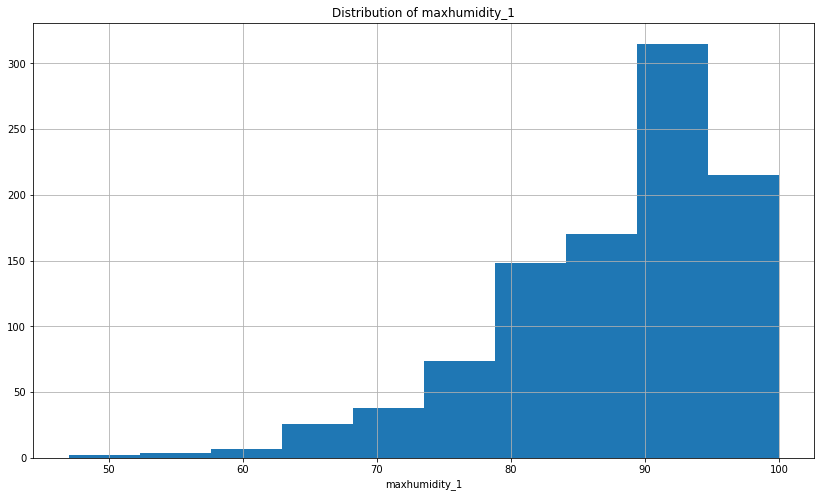

In [30]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]
df.maxhumidity_1.hist()
plt.title('Distribution of maxhumidity_1')
plt.xlabel('maxhumidity_1')
plt.show()

Looking at the histogram of the values for maxhumidity the data exhibits quite a bit of negative skew. I will want to keep this in mind when selecting prediction models and evaluating the strength of maxhumidities impact. Many of the underlying statistical methods assume that the data is normally distributed. For now I think I will leave them alone but it will be good to keep this in mind and have a certain amount of skepticism of it.

Next I will look at the minimum pressure feature distribution.

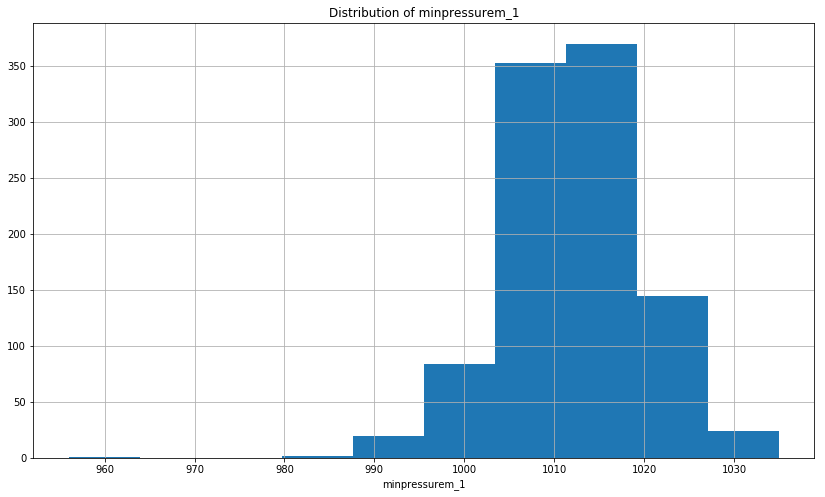

In [31]:
df.minpressurem_1.hist()
plt.title('Distribution of minpressurem_1')
plt.xlabel('minpressurem_1')
plt.show()

This plot exhibits another interesting feature. From this plot, the data is multimodal which leads me to believe that there are two very different sets of environmental circumstances apparent in this data. I am hesitant to remove these values since I know that the temperature swings in this area of the country can be quite extreme especially between seasons of the year. I am worried that removing these low values might have some explanatory usefulness but, once again I will be skeptical about it at the same time.

The final category of features containing outliers, precipitation, are quite a bit easier to understand. Since the dry days (ie, no precipitation) are much much more frequent it is sensible to see outliers here. To me this is no reason to remove these features. 

The last data quality issue to address is that of missing values. Due to the way in which I have built out the DataFrame the missing values are represented by Nans. You will probably remember that I have intentionally introduced missing values for the first three days of the data collected by deriving features representing the prior three days of measurements. It is not until the third day in that we can start deriving those features so, clearly, I will want to exclude those first three days from the data set.

Look again at the output from the last time I issued the info method. There is a column of output that listed the non-null values for each feature column. Looking at this information you can see that for the most part the features contain relatively few missing (null / nan) values, mostly just the ones I introduced. However, the precipitation columns appear to be missing a significant part of their data. Missing data poses a problem because most machine learning methods require complete data sets devoid of any missing data. Aside from the issue that many of the machine learning methods require complete data, if I were to remove all the rows just because the precipitation feature contains missing data then I would be throwing out many other useful feature measurements.

As I see it I have a couple of options to deal with this issue of missing data: (1) I can simply remove the rows that contain the missing values but, as I mentioned earlier throwing out that much data removes a lot of value from the data, or (2) I can fill the missing values with an interpolated value that is a reasonable estimation of the true values. Since I would rather preserve as much of the data as I can where there is minimal risk of introducing erroneous values I am going to fill the precipitation missing values with the most common value of zero. I feel this is a reasonable decision because the great majority of values in the precipitation measurements are zero.

In [17]:
# iterate over the precip columns
for precip_col in ['precipm_1', 'precipm_2', 'precipm_3']:
    # create a boolean array of values representing nans
    missing_vals = pd.isnull(df[precip_col])
    df[precip_col][missing_vals] = 0

/Users/adammcquistan/miniconda3/envs/alex-backend/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Now that I have filled all the missing values that I can while being cautious not to negatively impact the quality I would be comfortable simply removing the remaining records containing missing values from the data set.  To drop rows from the DataFrame containing Nans is quite easy.  All I have to do is call the method `dropna()` and Pandas will do all the work for me.

In [18]:
df = df.dropna()

### Conclusion

In this article, I have described the process of collecting, cleaning, and processing a reasonably good sized data set to be used for upcoming articles on a machine learning project to predict future weather temperatures.  While this is probably going to be the driest of the articles detaining this machine learning project I have tried to emphasize the importance of collecting quality data suitable for a valuable machine learning experiment.  

Thanks for reading and I hope you look forward to the upcoming articles on this project.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 997 entries, 2015-01-04 to 2017-09-27
Data columns (total 39 columns):
meantempm          997 non-null int64
maxtempm           997 non-null int64
mintempm           997 non-null int64
meantempm_1        997 non-null float64
meantempm_2        997 non-null float64
meantempm_3        997 non-null float64
meandewptm_1       997 non-null float64
meandewptm_2       997 non-null float64
meandewptm_3       997 non-null float64
meanpressurem_1    997 non-null float64
meanpressurem_2    997 non-null float64
meanpressurem_3    997 non-null float64
maxhumidity_1      997 non-null float64
maxhumidity_2      997 non-null float64
maxhumidity_3      997 non-null float64
minhumidity_1      997 non-null float64
minhumidity_2      997 non-null float64
minhumidity_3      997 non-null float64
maxtempm_1         997 non-null float64
maxtempm_2         997 non-null float64
maxtempm_3         997 non-null float64
mintempm_1         997 non-null float64
mi

In [23]:
import pickle
with open('end-part1_df.pkl', 'wb') as fp:
    pickle.dump(df, fp)